In [1]:
import tensorflow as tf
import tensornets as nets

from tensornets.datasets import voc

data_dir = '/home/taehoonlee/Data/VOCdevkit/VOC2007'
data_name = 'test'

In [2]:
inputs1 = tf.placeholder(tf.float32, [None, 416, 416, 3])
inputs2 = tf.placeholder(tf.float32, [None, None, None, 3])
models = []

with tf.device('gpu:0'):
    models += [nets.YOLOv2VOC(inputs1)]
    models += [nets.FasterRCNN_VGG16_VOC(inputs2)]

with tf.device('gpu:1'):
    models += [nets.TinyYOLOv2VOC(inputs1)]
    models += [nets.FasterRCNN_ZF_VOC(inputs2)]
    models += [nets.YOLOv3VOC(inputs1)]

In [3]:
imgs1 = voc.load(data_dir, data_name)
imgs2 = voc.load(data_dir, data_name, min_shorter_side=600)
results = [[] for _ in range(len(models))]

with tf.Session() as sess:
    nets.pretrained(models)
    for ((img1, scale1), (img2, scale2)) in zip(imgs1, imgs2):
        outs = sess.run(models[:-1] + models[-1].preds,
                        {inputs1: models[0].preprocess(img1),
                         inputs2: models[1].preprocess(img2),
                         models[1].scales: scale2,
                         models[3].scales: scale2})
        outs = outs[:-3] + [outs[-3:]]
        shapes = [img1.shape[1:3], img2.shape[1:3],
                  img1.shape[1:3], img2.shape[1:3], img1.shape[1:3]]
        for i in range(len(models)):
            results[i].append(models[i].get_boxes(outs[i], shapes[i]))

In [4]:
for result in results:
    print(voc.evaluate(result, data_dir, data_name))

| aeropl | bicycl |   bird |   boat | bottle |    bus |    car |    cat |  chair |    cow | dining |    dog |  horse | motorb | person | potted |  sheep |   sofa |  train | tvmoni |
|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
| 0.7801 | 0.7838 | 0.7026 | 0.6438 | 0.4671 | 0.7925 | 0.7977 | 0.8089 | 0.5757 | 0.7727 | 0.7321 | 0.8611 | 0.8108 | 0.7958 | 0.7569 | 0.5028 | 0.7582 | 0.7405 | 0.8058 | 0.7515 |
Mean = 0.7320
| aeropl | bicycl |   bird |   boat | bottle |    bus |    car |    cat |  chair |    cow | dining |    dog |  horse | motorb | person | potted |  sheep |   sofa |  train | tvmoni |
|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
| 0.6927 | 0.7870 | 0.6817 | 0.5497 | 0.4944 | 0.7733 | 0.7947 | 0.8435 | 0.

In [5]:
imgs1 = voc.load(data_dir, data_name, total_num=10)
imgs2 = voc.load(data_dir, data_name, min_shorter_side=600, total_num=10)
results = [[] for _ in range(len(models))]

with tf.Session() as sess:
    nets.pretrained(models)
    for ((img1, scale1), (img2, scale2)) in zip(imgs1, imgs2):
        outs = sess.run(models[:-1] + models[-1].preds,
                        {inputs1: models[0].preprocess(img1),
                         inputs2: models[1].preprocess(img2),
                         models[1].scales: scale2,
                         models[3].scales: scale2})
        outs = outs[:-3] + [outs[-3:]]
        shapes = [img1.shape[1:3], img2.shape[1:3],
                  img1.shape[1:3], img2.shape[1:3], img1.shape[1:3]]
        for i in range(len(models)):
            results[i].append(models[i].get_boxes(outs[i], shapes[i]))

cat: [129.         57.        231.        158.          0.4479985]
cat: [119.         79.        325.        298.          0.7081658]
dog: [150.         141.         334.         310.           0.37857455]


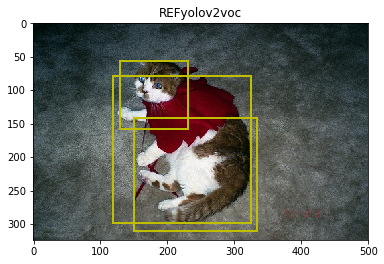

bird: [1.4402155e+02 1.0230472e+02 3.3691742e+02 3.2453848e+02 2.1283822e-01]
cat: [143.58208     49.31932    321.58752    319.8153       0.95143056]
cat: [128.78743    47.72542   238.46416   143.34717     0.7937706]
chair: [1.15613846e+02 2.94244385e+00 3.42978760e+02 3.40565582e+02
 8.59194919e-02]
dog: [1.5779935e+02 1.2793229e+02 3.2265912e+02 3.0532355e+02 1.2427439e-01]


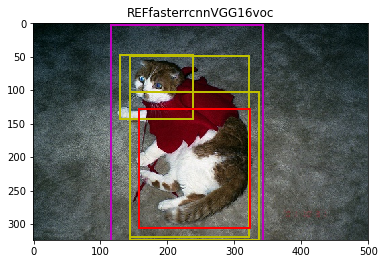

cat: [1.240000e+02 3.900000e+01 3.210000e+02 2.480000e+02 2.701884e-01]
dog: [140.          56.         301.         213.           0.60190094]
person: [1.2400000e+02 4.3000000e+01 3.1500000e+02 3.2300000e+02 1.3369529e-01]


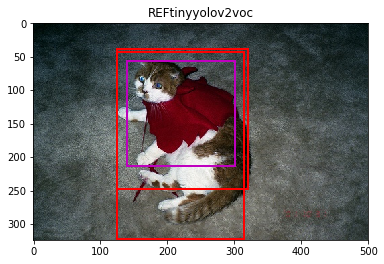

cat: [151.19046   150.34448   335.72888   301.4558      0.9034799]
cat: [160.86728     49.115936   300.21503    229.21729      0.49711815]
dog: [1.4292041e+02 5.2513870e+01 3.1246390e+02 3.1742523e+02 2.0652467e-01]


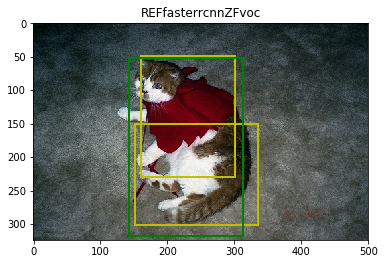

cat: [134.         66.        332.        302.          0.9915234]
dog: [141.         117.         310.         298.           0.38790184]


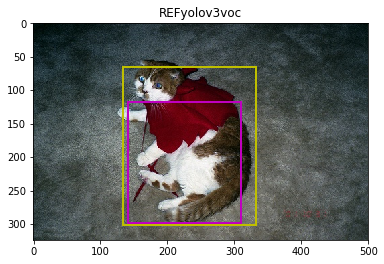

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

imgs2 = voc.load(data_dir, data_name, total_num=10)
imgs2 = [img for (img, scale) in imgs2]

imgidx = 7
for m in range(len(models)):
    plt.imshow(imgs2[imgidx][0,:,:,::-1].astype(np.uint8))
    for (c, b) in enumerate(results[m][imgidx]):
        if b.shape[0] > 0:
            for x in range(b.shape[0]):
                bbox = b[x]
                print("%s: %s" % (voc.classnames[c], bbox))
                plt.gca().add_patch(plt.Rectangle(
                    (bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False,
                    edgecolor='cmyrg'[np.random.randint(5)], linewidth=2))
    plt.title(models[m].aliases[-1])
    plt.show()